# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [ ]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug
!pip install jinja2==3.0



  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)
  Using cached Jinja2-3.0.0-py3-none-any.whl (133 kB)
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 3.1.2
    Uninstalling Jinja2-3.1.2:
      Successfully uninstalled Jinja2-3.1.2


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
from sagemaker import get_execution_role
from sagemaker.tuner import (IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner)
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
import boto3

role= sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [38]:
#TODO: Fetch and upload the data to AWS S3
inputs = "s3://sagemaker-us-east-1-071126781772/dogImages/"
print(inputs)
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip


s3://sagemaker-us-east-1-071126781772/dogImages/
--2023-03-19 22:04:57--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.194.72
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.194.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  48.7MB/s    in 29s     

2023-03-19 22:05:29 (37.8 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinsch

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [6]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges= {"lr": ContinuousParameter(0.001, 0.1),
                        "epochs":IntegerParameter(1,4),
                        "batch-size":CategoricalParameter([32, 64, 128, 256, 512])}

objective_metric_name= "Test Loss"
objective_type= "Minimize"
metric_definition= [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [7]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point = "hpo.py",
    role= role,
    py_version="py36",
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)# TODO: Your estimator here

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definition,
    max_jobs=6,
    max_parallel_jobs=2,
    objective_type= objective_type
)
    # TODO: Your HP tuner here

In [8]:
# TODO: Fit your HP Tuner
tuner.fit({"training":inputs}) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [9]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()
#TODO

#Get the hyperparameters of the best trained model
HP_best_trained = best_estimator.hyperparameters()



2023-03-17 23:09:17 Starting - Found matching resource for reuse
2023-03-17 23:09:17 Downloading - Downloading input data
2023-03-17 23:09:17 Training - Training image download completed. Training in progress.
2023-03-17 23:09:17 Uploading - Uploading generated training model
2023-03-17 23:09:17 Completed - Resource retained for reuse


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [11]:

hyperparameters = {"batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')), \
                   "epochs":best_estimator.hyperparameters()['epochs'], "lr": best_estimator.hyperparameters()['lr']}
hyperparameters

{'batch-size': 64, 'epochs': '4', 'lr': '0.0017774398076876958'}

In [6]:
import os
os.environ['SM_CHANNEL_TRAINING']='s3://sagemaker-us-east-1-071126781772/dogImages/'
os.environ['SM_MODEL_DIR']='s3://sagemaker-us-east-1-071126781772/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://sagemaker-us-east-1-071126781772/output/'

inputs="s3://sagemaker-us-east-1-071126781772/dogImages/"

In [7]:
# TODO: Set up debugging and profiling rules and hooks

hyperparameters = {"batch-size":"64" , 
                   "epochs":"4",
                   "lr":'0.0017774398076876958' }


rules = [ Rule.sagemaker(rule_configs.vanishing_gradient()),
          Rule.sagemaker(rule_configs.overfit()),
          Rule.sagemaker(rule_configs.overtraining()),
          Rule.sagemaker(rule_configs.poor_weight_initialization()),
          ProfilerRule.sagemaker(rule_configs.ProfilerReport()) ]

from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
profiler_config = ProfilerConfig(system_monitor_interval_millis=500, framework_profile_params = FrameworkProfile(num_steps=10))
debugger_config = DebuggerHookConfig(hook_parameters={"train.save_interval":"10", "test.save_interval":"1"})
        


In [8]:
# TODO: Create and fit an estimator
# TODO: Your estimator here
estimator = PyTorch(entry_point="train_model.py", 
                    role = role,
                    instance_count=1,
                    instance_type= "ml.m5.xlarge",
                    hyperparameters = hyperparameters,
                    framework_version="1.8",
                    py_version="py36",
                    rules= rules,
                    profiler_config= profiler_config,
                    debugger_hook_config= debugger_config)

estimator.fit({"training":inputs})


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-03-17-19-51-36-664


2023-03-17 19:51:38 Starting - Starting the training job...
2023-03-17 19:52:07 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2023-03-17 19:52:40 Downloading - Downloading input data.........
2023-03-17 19:54:08 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-17 19:54:01,292 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-17 19:54:01,294 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-17 19:54:01,303 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-17 19:54:01,305 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-03-17 19:54:01,537 sagem

[2023-03-17 20:16:58.260 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:17 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-03-17 20:16:58.270 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:17 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-509200330118/pytorch-training-2023-03-17-19-51-36-664/debug-output
[2023-03-17 20:16:59.157 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:17 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-03-17 20:17:00.178 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:17 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input

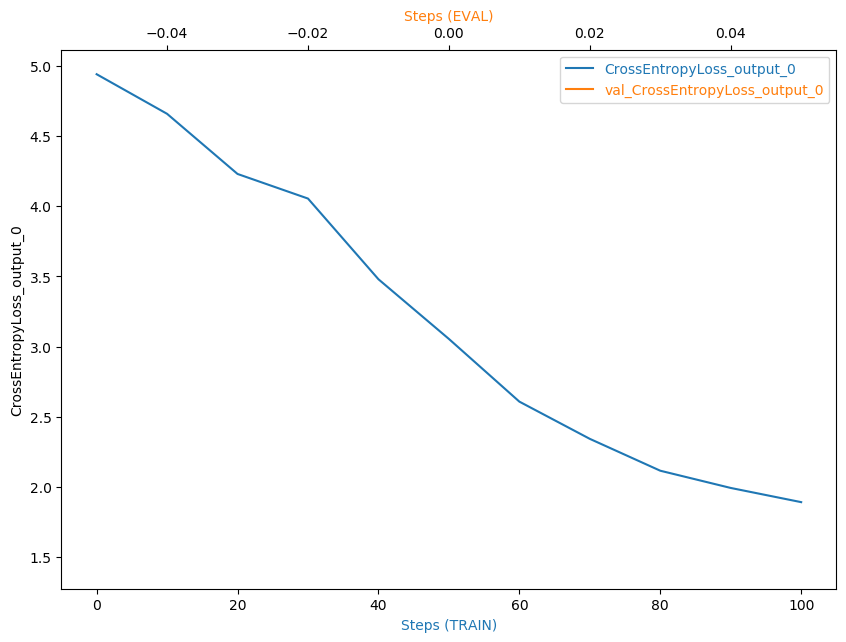

In [9]:
# TODO: Plot a debugging output.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
describtion = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
trial = create_trial(estimator.latest_job_debugger_artifacts_path())
print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

#Set up functions to plot the output tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [10]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
! aws s3 ls {rule_output_path} --recursive

2023-03-17 20:16:08     375268 pytorch-training-2023-03-17-19-51-36-664/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-03-17 20:16:07     223185 pytorch-training-2023-03-17-19-51-36-664/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-03-17 20:16:02        192 pytorch-training-2023-03-17-19-51-36-664/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-03-17 20:16:02        200 pytorch-training-2023-03-17-19-51-36-664/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-03-17 20:16:02       1932 pytorch-training-2023-03-17-19-51-36-664/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-03-17 20:16:02        127 pytorch-training-2023-03-17-19-51-36-664/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-03-17 20:16:02        199 pytorch-training-2023-03-17-19-51-36-664/rule-output/ProfilerReport/profiler-output/profiler-re

In [12]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-509200330118/pytorch-training-2023-03-17-19-51-36-664/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-509200330118/pytorch-training-2023-03-17-19-51-36-664/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-509200330118/pytorch-training-2023-03-17-19-51-36-664/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-509200330118/pytorch-training-2023-03-17-19-51-36-664/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-509200330118/pytorch-training-2023-03-17-

In [15]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [13]:
#training_job_name = estimator.latest_training_job.name
#print(training_job_name)
#latest_training_job='pytorch-training-2023-03-07-21-36-46-326'
#estimator = sagemaker.estimator.Estimator.attach(latest_training_job)

In [16]:
# TODO: Display the profiler output
from jinja2.utils import markupsafe 
from markupsafe import Markup
session = boto3.session.Session()
region = session.region_name
training_job_name = estimator.latest_training_job.name
print(f"training jobname:{training_job_name}")
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)


training jobname:pytorch-training-2023-03-17-19-51-36-664


ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-509200330118/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-509200330118/pytorch-training-2023-03-17-19-51-36-664/profiler-output


Profiler data from system is available


[2023-03-17 20:19:21.897 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:17 INFO metrics_reader_base.py:134] Getting 24 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


In [17]:
#latest_training_job='pytorch-training-2023-03-07-07-06-38-662'
#my_estimator = sagemaker.estimator.Estimator.attach(latest_training_job)

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-509200330118/pytorch-training-2023-03-17-19-51-36-664/rule-output


In [18]:
! aws s3 ls {rule_output_path} --recursive

2023-03-17 20:16:08     375268 pytorch-training-2023-03-17-19-51-36-664/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-03-17 20:16:07     223185 pytorch-training-2023-03-17-19-51-36-664/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-03-17 20:16:02        192 pytorch-training-2023-03-17-19-51-36-664/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-03-17 20:16:02        200 pytorch-training-2023-03-17-19-51-36-664/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-03-17 20:16:02       1932 pytorch-training-2023-03-17-19-51-36-664/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-03-17 20:16:02        127 pytorch-training-2023-03-17-19-51-36-664/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-03-17 20:16:02        199 pytorch-training-2023-03-17-19-51-36-664/rule-output/ProfilerReport/profiler-output/profiler-re

In [21]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-509200330118/pytorch-training-2023-03-17-19-51-36-664/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-509200330118/pytorch-training-2023-03-17-19-51-36-664/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-509200330118/pytorch-training-2023-03-17-19-51-36-664/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-509200330118/pytorch-training-2023-03-17-19-51-36-664/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-509200330118/pytorch-training-2023-03-17-19-51-36-664/rule-outp

In [22]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [7]:
# train hpo.py again using best hyperparameters to be used in the deployment instance

hyperparameters = {"batch-size":"64" , 
                   "epochs":"4",
                   "lr":'0.0017774398076876958' }


rules = [ Rule.sagemaker(rule_configs.vanishing_gradient()),
          Rule.sagemaker(rule_configs.overfit()),
          Rule.sagemaker(rule_configs.overtraining()),
          Rule.sagemaker(rule_configs.poor_weight_initialization()),
          ProfilerRule.sagemaker(rule_configs.ProfilerReport()) ]

from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
profiler_config = ProfilerConfig(system_monitor_interval_millis=500, framework_profile_params = FrameworkProfile(num_steps=10))
debugger_config = DebuggerHookConfig(hook_parameters={"train.save_interval":"100", "test.save_interval":"10"})
        

In [8]:
estimator = PyTorch(entry_point="hpo.py", 
                    base_job_name='separatedeployscript',
                    role = role,
                    instance_count=1,
                    instance_type= "ml.m5.xlarge",
                    hyperparameters = hyperparameters,
                    framework_version="1.8",
                    py_version="py36",
                    rules= rules,
                    profiler_config= profiler_config,
                    debugger_hook_config= debugger_config)

estimator.fit({"training":inputs})


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: separatedeployscript-2023-03-19-21-25-58-103


2023-03-19 21:26:00 Starting - Starting the training job...
2023-03-19 21:26:36 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2023-03-19 21:27:08 Downloading - Downloading input data......
2023-03-19 21:28:08 Training - Downloading the training image...
2023-03-19 21:28:39 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-19 21:28:22,040 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-19 21:28:22,042 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-19 21:28:22,051 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-19 21:28:22,053 sagemaker_pytorch_container.training INFO   

In [9]:
#latest_training_job='separatedeployscript-2023-03-15-21-14-45-478'
#estimator = sagemaker.estimator.Estimator.attach(latest_training_job)

In [9]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [12]:
model_location=estimator.model_data
print(model_location)

s3://sagemaker-us-east-1-071126781772/separatedeployscript-2023-03-19-21-25-58-103/output/model.tar.gz


In [15]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )
        

In [16]:
pytorch_model = PyTorchModel(model_data="s3://sagemaker-us-east-1-071126781772/separatedeployscript-2023-03-19-21-25-58-103/output/model.tar.gz", role=role, entry_point='infernce_1.py',py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)


In [17]:
# TODO: Deploy your model to an endpoint

predictor=pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large') # TODO: Add your deployment configuration like instance type and number of instances

INFO:sagemaker:Creating model with name: pytorch-inference-2023-03-19-21-50-19-187
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-03-19-21-50-19-928
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-03-19-21-50-19-928


-----!

In [61]:
# TODO: Run an prediction on the endpoint
from PIL import Image
import io
import requests
#request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

# TODO: Your code to load and preprocess image to send to endpoint for prediction
img_bytes = requests.get(request_dict['url']).content
type(img_bytes)


bytes

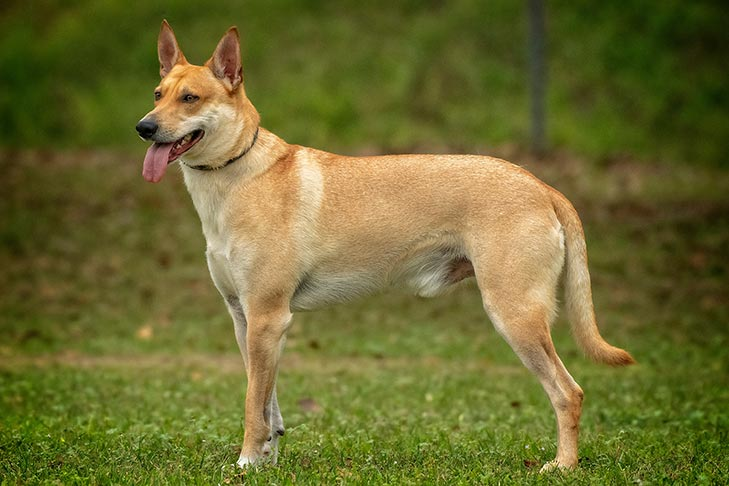

In [62]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [63]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})


In [64]:
import json
response2=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})
type(response2[0][0])



float

In [65]:
response2[0]

[-6.531435966491699,
 -2.209101676940918,
 -3.8572161197662354,
 0.1459377408027649,
 -3.708247184753418,
 -2.4279942512512207,
 -0.693605899810791,
 -0.8215091228485107,
 -4.915270805358887,
 -0.8241432905197144,
 -0.9897979497909546,
 -1.2842731475830078,
 -1.0968592166900635,
 1.2039854526519775,
 -3.7468719482421875,
 -0.7168641090393066,
 -5.7141947746276855,
 -3.0484232902526855,
 -5.4267988204956055,
 1.7122012376785278,
 -2.909660816192627,
 0.311557799577713,
 -7.81561279296875,
 -5.938201427459717,
 -3.405346393585205,
 -6.7229437828063965,
 -1.5210868120193481,
 -3.3095524311065674,
 -3.4594366550445557,
 -2.986349582672119,
 0.4653964042663574,
 -3.2781455516815186,
 -6.824100494384766,
 -2.660057783126831,
 -5.218965530395508,
 -7.101377010345459,
 -3.398311138153076,
 -2.403671979904175,
 0.5160068273544312,
 -3.9830679893493652,
 -4.076307773590088,
 -2.975620985031128,
 1.3321477174758911,
 -3.369256019592285,
 0.5881102085113525,
 -6.192429065704346,
 -0.60302925109863

In [27]:
!pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 34.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 994.6 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 39.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 13.8 MB/s eta 0:00:0000:01


In [66]:
import torch
import numpy as np
np.argmax(response, 1)

array([19])

The image label is: 51


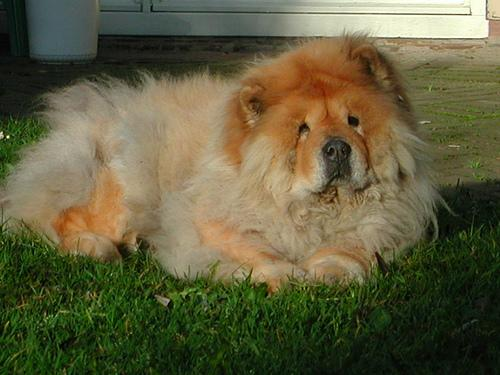

In [77]:
#run prediction on an endpoint using an image

image = 'dogImages/test/051.Chow_chow/Chow_chow_03591.jpg'
        #'dogImages/test/093.Kerry_blue_terrier/Kerry_blue_terrier_06291.jpg'
        #'dogImages/test/015.Basset_hound/Basset_hound_01059.jpg'
target_str = 'test/'
img_num= image.index(target_str) + len(target_str)
label = int(image[img_num:img_num+3])
# Displaying image to be predicted
img = Image.open(image)
print('The image label is: {}'.format(label))
display(img)



In [68]:
image_bytes = open(image, 'rb').read()
response = predictor.predict(image_bytes, initial_args={'ContentType':'image/jpeg'})
response[0]

[-3.9009220600128174,
 -1.3751451969146729,
 -4.91927433013916,
 0.3173556327819824,
 1.0382250547409058,
 2.1922881603240967,
 -3.2383294105529785,
 -3.556386947631836,
 -3.1512558460235596,
 -2.7155754566192627,
 -3.1621482372283936,
 -1.6155579090118408,
 -1.5113623142242432,
 -4.264596939086914,
 -2.401256799697876,
 -3.1593778133392334,
 -2.6004021167755127,
 -7.138988018035889,
 -4.724654674530029,
 -5.276142597198486,
 -1.8145774602890015,
 -1.3413699865341187,
 -4.003190994262695,
 0.37070274353027344,
 -6.765291213989258,
 -5.386559963226318,
 -2.662769317626953,
 -1.6027371883392334,
 -2.1064257621765137,
 -3.4502835273742676,
 0.4989314079284668,
 -8.96286678314209,
 -1.8979097604751587,
 -6.216335296630859,
 -5.5996994972229,
 -3.2858831882476807,
 -4.266505718231201,
 -4.706089496612549,
 -4.58653450012207,
 -3.5782670974731445,
 -6.743475437164307,
 -1.0098888874053955,
 -2.7141191959381104,
 -5.34398078918457,
 -3.1197807788848877,
 -3.962798833847046,
 -4.33219766616821

In [69]:

prediction = np.argmax(response[0]) + 1       
print(prediction)

51


In [70]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-03-19-21-50-19-928
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-03-19-21-50-19-928
